[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 291, number of used features: 6
[LightGBM] [Info] Start training from score 44.896438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

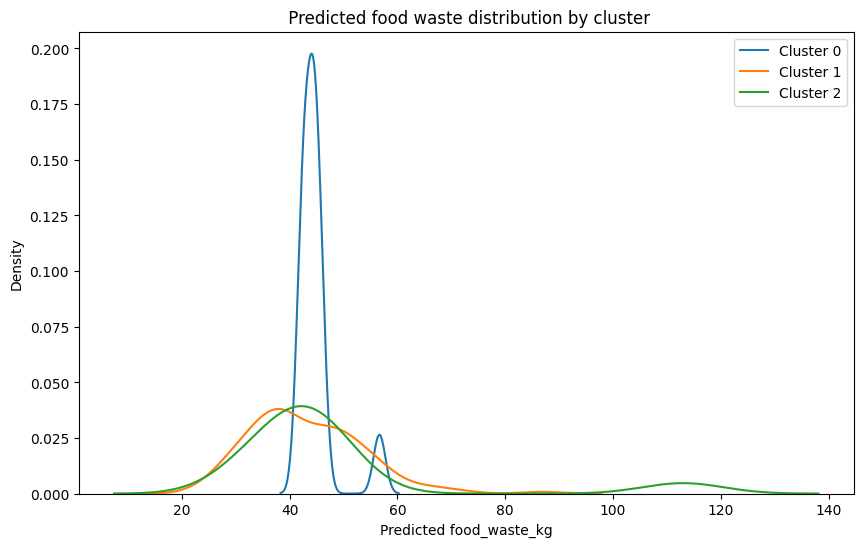

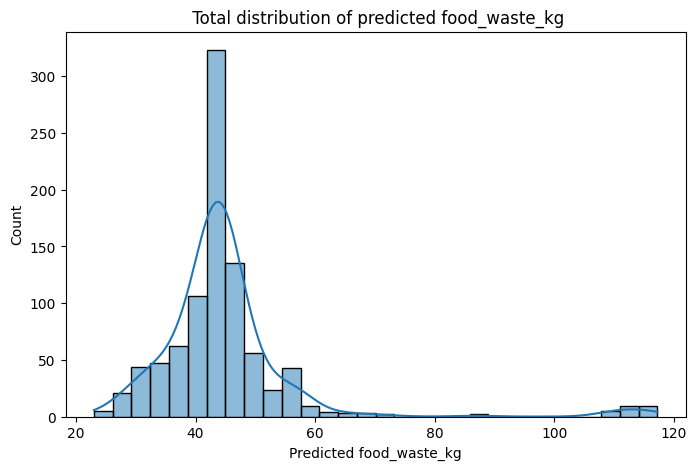

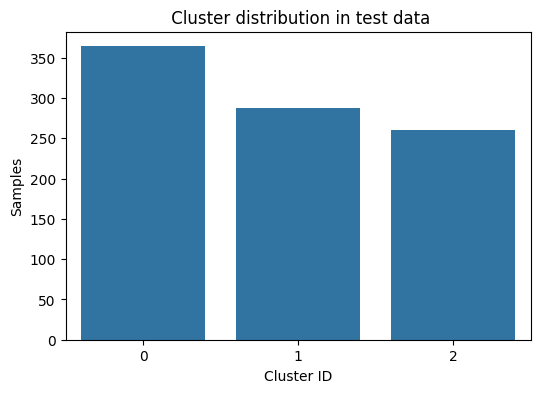

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor, early_stopping
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로딩
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 2. 전처리 함수 정의
def preprocess(data, is_train=True):
    data = data.copy()
    data.drop(columns=["date", "ID"], inplace=True, errors='ignore')
    data['staff_experience'] = data['staff_experience'].astype(str).str.lower().str.strip()
    data['waste_category'] = data['waste_category'].astype(str).str.lower().str.strip()
    data['staff_experience'] = data['staff_experience'].replace(['nan', 'none', 'NaN'], np.nan)

    mode_temp = data['temperature_C'][(data['temperature_C'] >= 10) & (data['temperature_C'] <= 40)].mode()
    if not mode_temp.empty:
        mode_temp = mode_temp[0]
        data['temperature_C'] = data['temperature_C'].clip(lower=10, upper=40).fillna(mode_temp)

    if 'past_waste_kg' in data.columns:
        data['past_waste_kg'] = data['past_waste_kg'].fillna(data['past_waste_kg'].mean())

    # 경험 규칙 기반 보정
    def fill_staff_exp(row):
        if pd.isnull(row['staff_experience']):
            staff = row['kitchen_staff']
            waste = row.get('past_waste_kg', 15)
            meals = row['meals_served']
            if staff <= 12 and waste >= 20:
                return 'beginner'
            elif staff >= 18 and waste <= 12:
                return 'expert'
            elif meals >= 80 and 12 < waste < 20:
                return 'intermediate'
            else:
                return 'intermediate'
        return row['staff_experience']

    data['staff_experience'] = data.apply(fill_staff_exp, axis=1)
    data['staff_experience'] = data['staff_experience'].map({'beginner': 0, 'intermediate': 1, 'expert': 2})

    data['special_event'] = data['special_event'].replace({'no': 0, 'yes': 1})
    data['special_event'] = data['special_event'].fillna(data['special_event'].mode()[0])

    if data['day_of_week'].isnull().any():
        data['day_of_week'] = data['day_of_week'].fillna("unknown")
    data['day_of_week'] = LabelEncoder().fit_transform(data['day_of_week'])

    return data

# 3. 전처리 적용
df = preprocess(df)
test = preprocess(test, is_train=False)

# 4. 특성 정의
features = ['temperature_C', 'humidity_percent', 'meals_served', 'kitchen_staff',
            'staff_experience', 'special_event', 'day_of_week']
target = 'food_waste_kg'

# 5. 결측치 채우기
imputer = SimpleImputer(strategy='mean')
df[features] = imputer.fit_transform(df[features])
test[features] = imputer.transform(test[features])

# 6. 정규화 및 클러스터링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)
test['cluster'] = kmeans.predict(scaler.transform(test[features]))

# 7. 클러스터별 모델 학습 및 예측
predictions = []

for cid in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cid]
    X = cluster_data[features]
    y = cluster_data[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LGBMRegressor(
        n_estimators=1000, learning_rate=0.01,
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
    )

    val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, val_pred)
    print(f"✅ Cluster {cid} → MSE: {mse:.4f}, Samples: {len(X_train)}")

    # test 예측
    test_cluster = test[test['cluster'] == cid].copy()
    test_cluster['predicted_waste'] = model.predict(test_cluster[features])
    predictions.append(test_cluster)

# 8. test 예측 결과 통합
test_pred = pd.concat(predictions).sort_index()

# 9. 시각화
plt.figure(figsize=(10,6))
for cid in sorted(test_pred['cluster'].unique()):
    sns.kdeplot(test_pred[test_pred['cluster'] == cid]['predicted_waste'], label=f"Cluster {cid}")
plt.title(" Predicted food waste distribution by cluster")
plt.xlabel("Predicted food_waste_kg")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(test_pred['predicted_waste'], bins=30, kde=True)
plt.title(" Total distribution of predicted food_waste_kg")
plt.xlabel("Predicted food_waste_kg")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='cluster', data=test_pred)
plt.title(" Cluster distribution in test data")
plt.xlabel("Cluster ID")
plt.ylabel("Samples")
plt.show()